In [185]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import pandas as pd
import os
import math

plt.style.use("mystyle.mplstyle")

g = 9.81

In [186]:
dataframes = dict()

for root, dirs, files in os.walk("./data"):
    for file in files:
        if ".csv" in file:
            current_file_path = os.path.join(root, file).replace("\\", "/")
            dataframes[file] = pd.read_csv(current_file_path, sep=';', decimal=',')
    break  # stop at first recursion level: only ./data

# for name,df in dataframes.items():
    # df.info()
    # fig,ax = plt.subplots()
    # ax.plot(df.iloc[])

In [187]:
def linear_damped_oscillator(t, amplitude, gamma, omega_zero, phase):
    return amplitude * np.exp(-gamma * t) * np.sin(omega_zero * t + phase)

def viscous_damped_oscillator(t, amplitude, alpha, omega_zero, phase):
    return (1 / (1 + amplitude * alpha * t)) * np.cos(omega_zero * t + phase)

def calc_lin_reg(x: list, y: list, x_errs: list, y_errs: list, m_test: float):
    # y = Ax + B
    N = len(x)

    for i in range(N):
        y_errs[i] = math.sqrt(y_errs[i] ** 2 + m_test**2 * x_errs[i] ** 2)

    sum_x2 = 0
    sum_x = 0
    sum_y = 0
    sum_xy = 0
    sum_sigma_y2 = 0

    for i in range(N):
        sum_x += x[i] / y_errs[i] ** 2
        sum_x2 += x[i] ** 2 / y_errs[i] ** 2
        sum_y += y[i] / y_errs[i] ** 2
        sum_xy += x[i] * y[i] / y_errs[i] ** 2
        sum_sigma_y2 += 1 / (y_errs[i] ** 2)

    delta = sum_sigma_y2 * sum_x2 - sum_x**2
    A = (1 / delta) * (sum_sigma_y2 * sum_xy - sum_x * sum_y)
    B = (1 / delta) * (sum_x2 * sum_y - sum_x * sum_xy)
    sA = math.sqrt((1 / delta) * sum_x2)
    sB = math.sqrt((1 / delta) * sum_sigma_y2)

    sigma_y = []
    for i in range(len(y_errs)):
        sigma_y.append(math.sqrt(y_errs[i] ** 2 + (m_test**2) * (x_errs[i] ** 2)))

    return (A, B, sA, sB, sigma_y)


def calc_chi_sqr(observed, expected, sigma_y, deg_of_freedom: int):
    chi2i = np.divide(np.square(observed - expected), np.square(sigma_y))
    chi2 = np.sum(chi2i)
    chi2r = chi2 / deg_of_freedom
    return (chi2i, chi2, chi2r)


In [188]:
### k estimate ###

"""
dfs = [dataframes["Misure k statiche non_pretensionata.csv"], dataframes["Misure k statiche pretensionata.csv"]]

masses = g * np.array([])
positions = []
positions_errs = []

for df in dfs:
    for i in range(3):
        # X = np.linspace(0, len(df.iloc[:,i]), len(df.iloc[:,i]))
        signal = df.iloc[:,i]
        mean_pos = np.mean(signal)
        sigma_mean_pos = np.std(signal) / np.sqrt(len(signal))
        positions.append(mean_pos)
        positions_errs.append(sigma_mean_pos)

k_estimates = {
    "non_pretensionata": calc_lin_reg(),
    "pretensionata": 0
}
"""

'\ndfs = [dataframes["Misure k statiche non_pretensionata.csv"], dataframes["Misure k statiche pretensionata.csv"]]\n\nmasses = g * np.array([])\npositions = []\npositions_errs = []\n\nfor df in dfs:\n    for i in range(3):\n        # X = np.linspace(0, len(df.iloc[:,i]), len(df.iloc[:,i]))\n        signal = df.iloc[:,i]\n        mean_pos = np.mean(signal)\n        sigma_mean_pos = np.std(signal) / np.sqrt(len(signal))\n        positions.append(mean_pos)\n        positions_errs.append(sigma_mean_pos)\n\nk_estimates = {\n    "non_pretensionata": calc_lin_reg(),\n    "pretensionata": 0\n}\n'

/tmp/ipykernel_1100/4046343101.py:2: RuntimeWarning: overflow encountered in exp
  return amplitude * np.exp(-gamma * t) * np.sin(omega_zero * t + phase)
/tmp/ipykernel_1100/4046343101.py:2: RuntimeWarning: overflow encountered in multiply
  return amplitude * np.exp(-gamma * t) * np.sin(omega_zero * t + phase)
/tmp/ipykernel_1100/4046343101.py:2: RuntimeWarning: overflow encountered in exp
  return amplitude * np.exp(-gamma * t) * np.sin(omega_zero * t + phase)
/tmp/ipykernel_1100/1658958289.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  linear_fit_args, _ = curve_fit(linear_damped_oscillator, X, Y)
/tmp/ipykernel_1100/4046343101.py:2: RuntimeWarning: overflow encountered in multiply
  return amplitude * np.exp(-gamma * t) * np.sin(omega_zero * t + phase)
/tmp/ipykernel_1100/4046343101.py:2: RuntimeWarning: overflow encountered in exp
  return amplitude * np.exp(-gamma * t) * np.sin(omega_zero * t + phase)
/tmp/ipykernel_1100/4046343101.py:2: RuntimeWarn

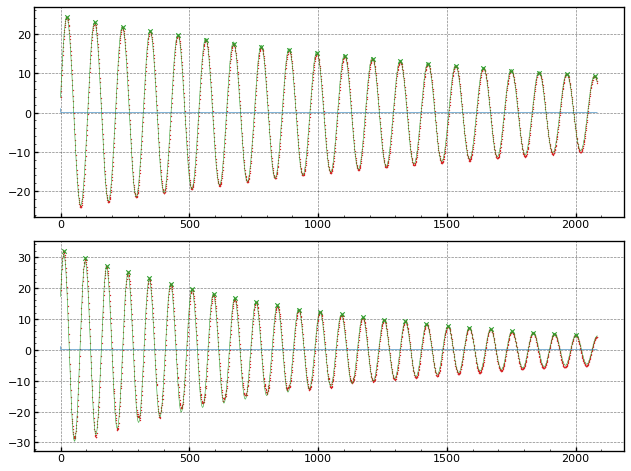

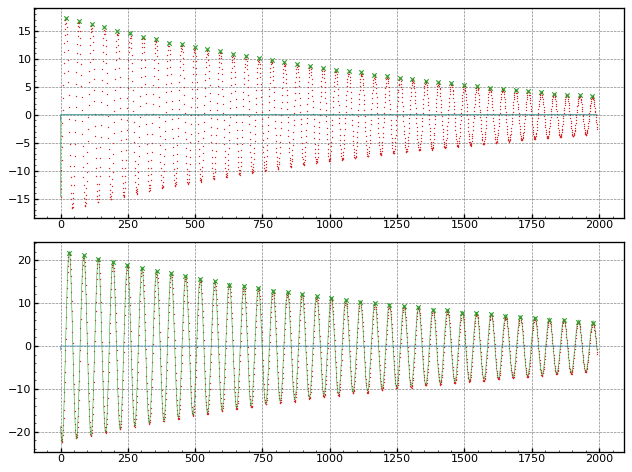

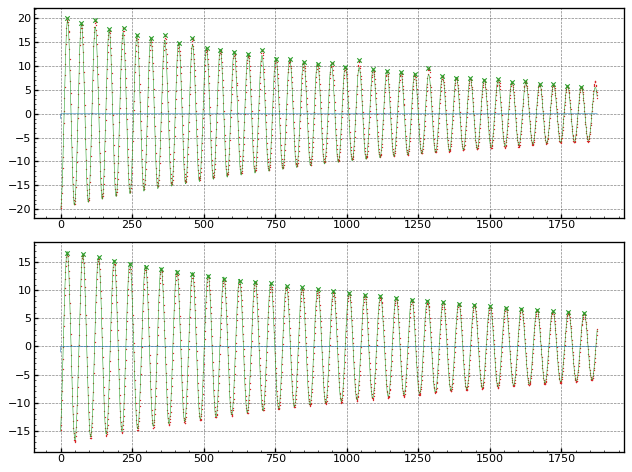

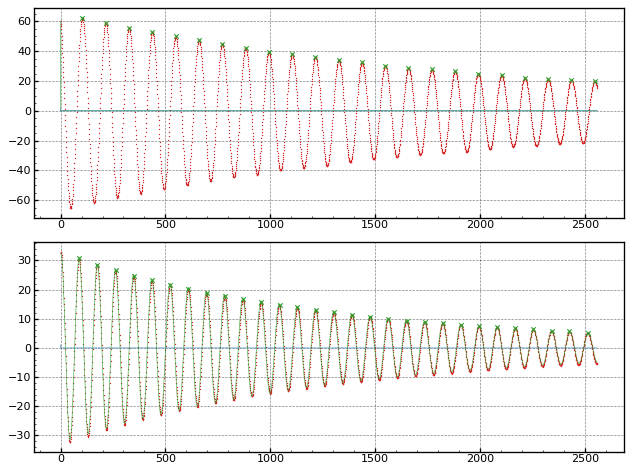

In [189]:
### C2 = 0 ###

masses = {
    # 3 masse, 1 massa
    "non_pretensionata": {
        "CD": [94.72, 55.19],
        "Rete": [90.18, 50.63]
    },
    # 5 masse, 7 masse
    "pretensionata": {
        "CD": [134.36, 173.94],
        "Rete": [129.81, 169.38]
    }
}

for name,df in filter(lambda e: "Oscillazioni" in e[0], dataframes.items()):
    spring = "non_pretensionata" if "non_pretensionata" in name else "pretensionata"
    damper = "CD" if "_cd_" in name else "Rete"

    df.dropna(inplace=True)
    fig,ax = plt.subplots(2)

    for i in range(2):
        X = np.linspace(0, len(df.iloc[:,i]), len(df.iloc[:,i]))
        Y = df.iloc[:,i]
        
        peaks_pos, _ = find_peaks([y if y >= 0 else 0 for y in Y], width=10)
        peaks = [Y[i] for i in peaks_pos]

        linear_fit_args, _ = curve_fit(linear_damped_oscillator, X, Y)
        viscous_fit_args, _ = curve_fit(viscous_damped_oscillator, X, Y)
        
        ax[i].scatter(X, Y, s=1.5, c='tab:red')
        ax[i].scatter(peaks_pos, peaks, marker='x', c='tab:green')
        ax[i].plot(X, linear_damped_oscillator(X, *linear_fit_args), linewidth=0.5, c='tab:green')
        ax[i].plot(X, viscous_damped_oscillator(X, *viscous_fit_args), linewidth=0.5, c='tab:blue')